<a href="https://colab.research.google.com/github/shuuuuyu/114-1-Programing-Language/blob/main/hw_6_%E8%AA%B2%E8%A1%A8%E6%9F%A5%E8%A9%A2%E8%88%87%E6%8F%90%E9%86%92%E7%B4%A0%E6%9D%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI 課表助理系統
讓課表管理變得更智慧、更高效、更有趣!
透過 AI 技術,將枯燥的課表轉化為:

- ✨ 貼心的每日提醒
- 📊 清晰的週次規劃
- 💡 實用的學習建議
- 🎨 個性化的互動體驗

[Google sheet](https://docs.google.com/spreadsheets/d/1CUr4MiWalSyXwTVjteZ_FCrFEIoDzs2QidUomHzLdeg/edit?gid=400139498#gid=400139498)


## 畫面截圖

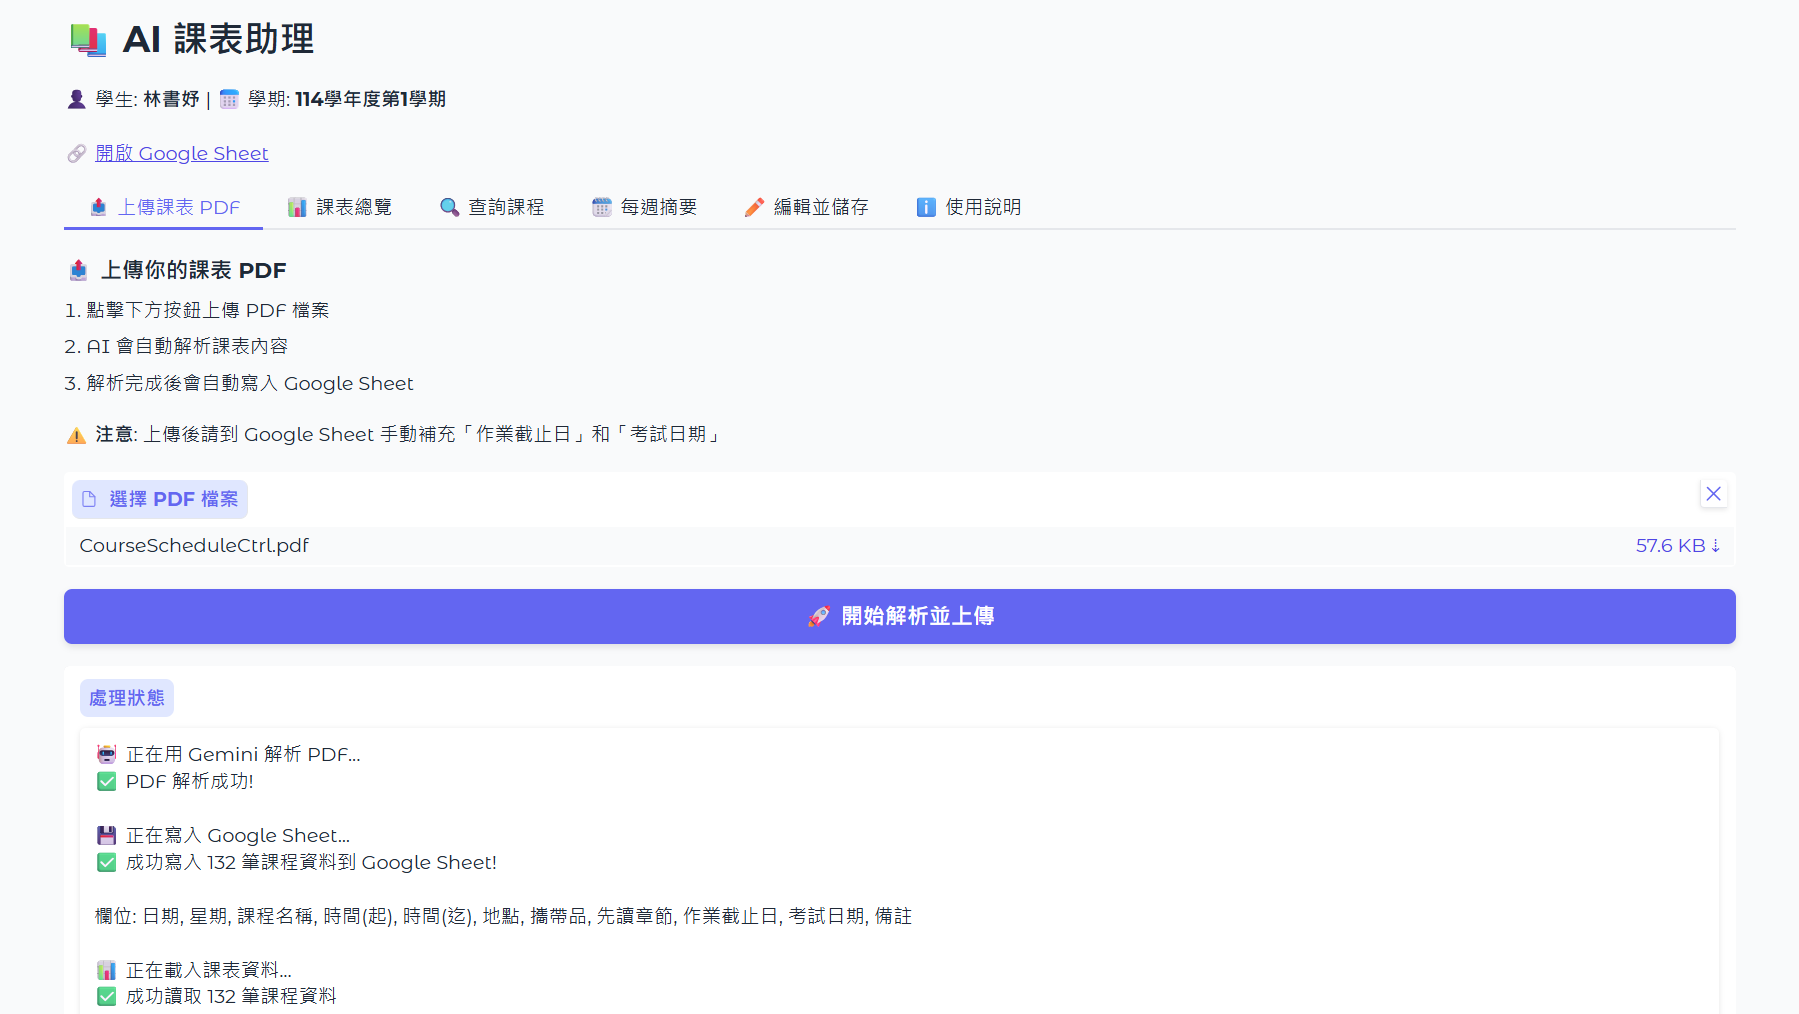

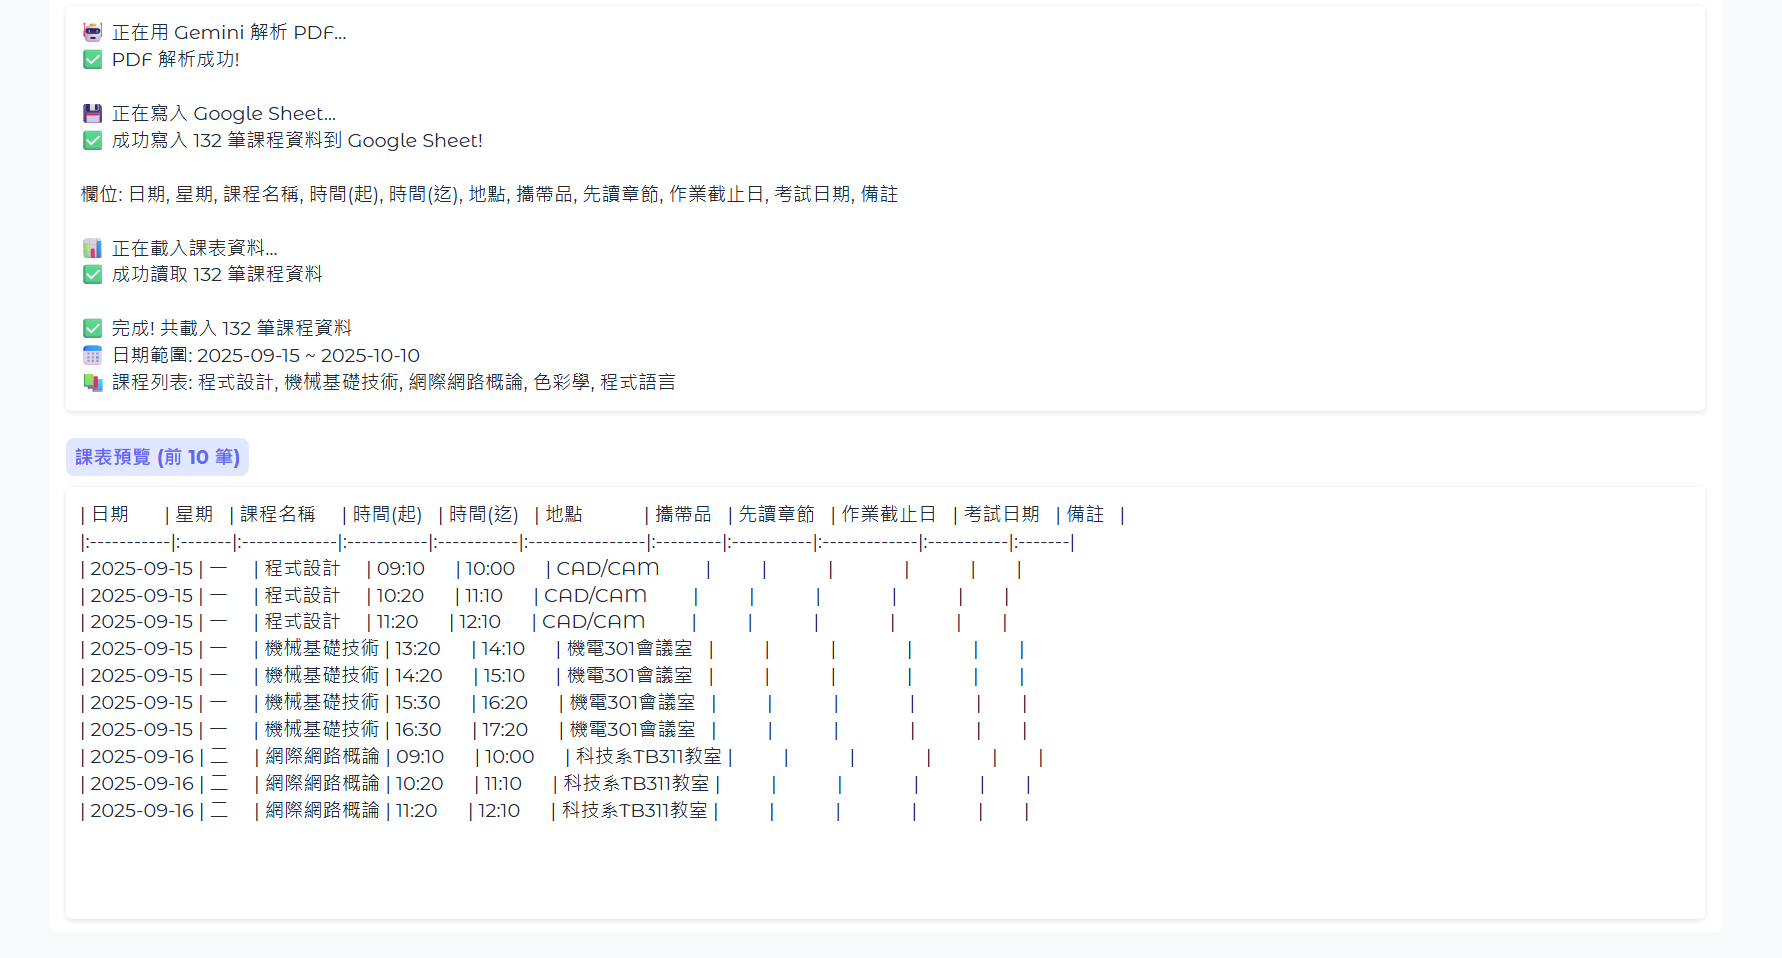

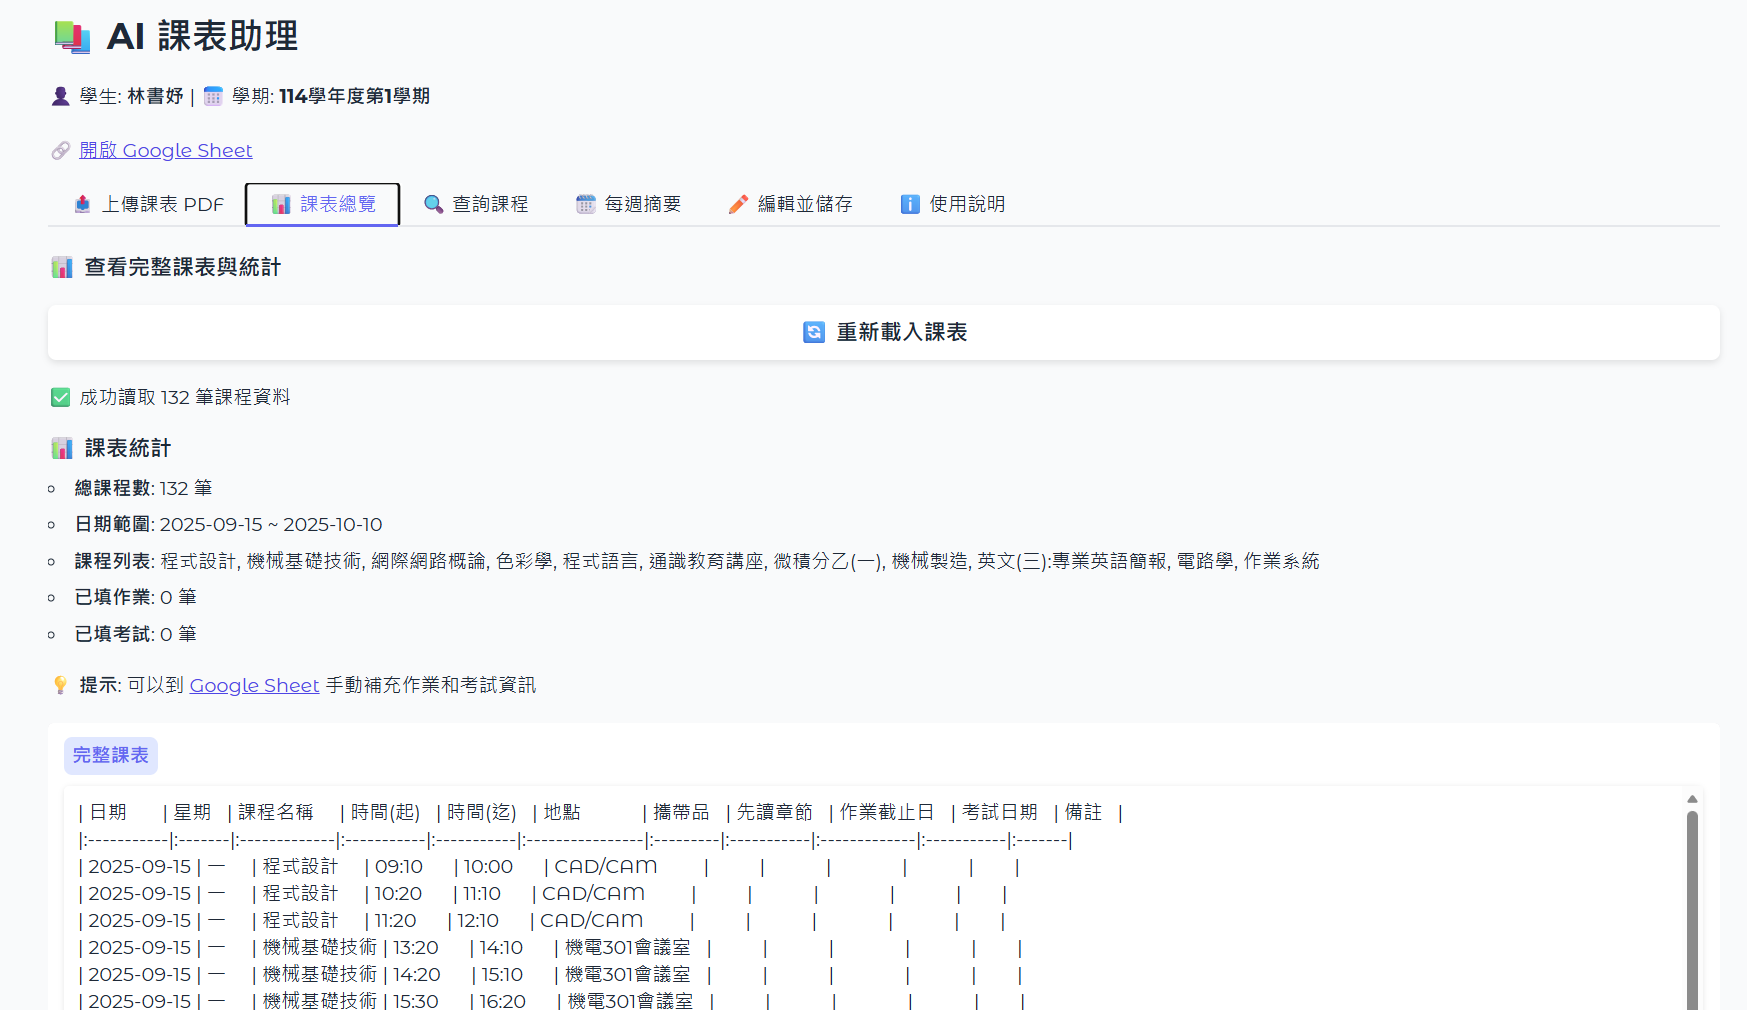

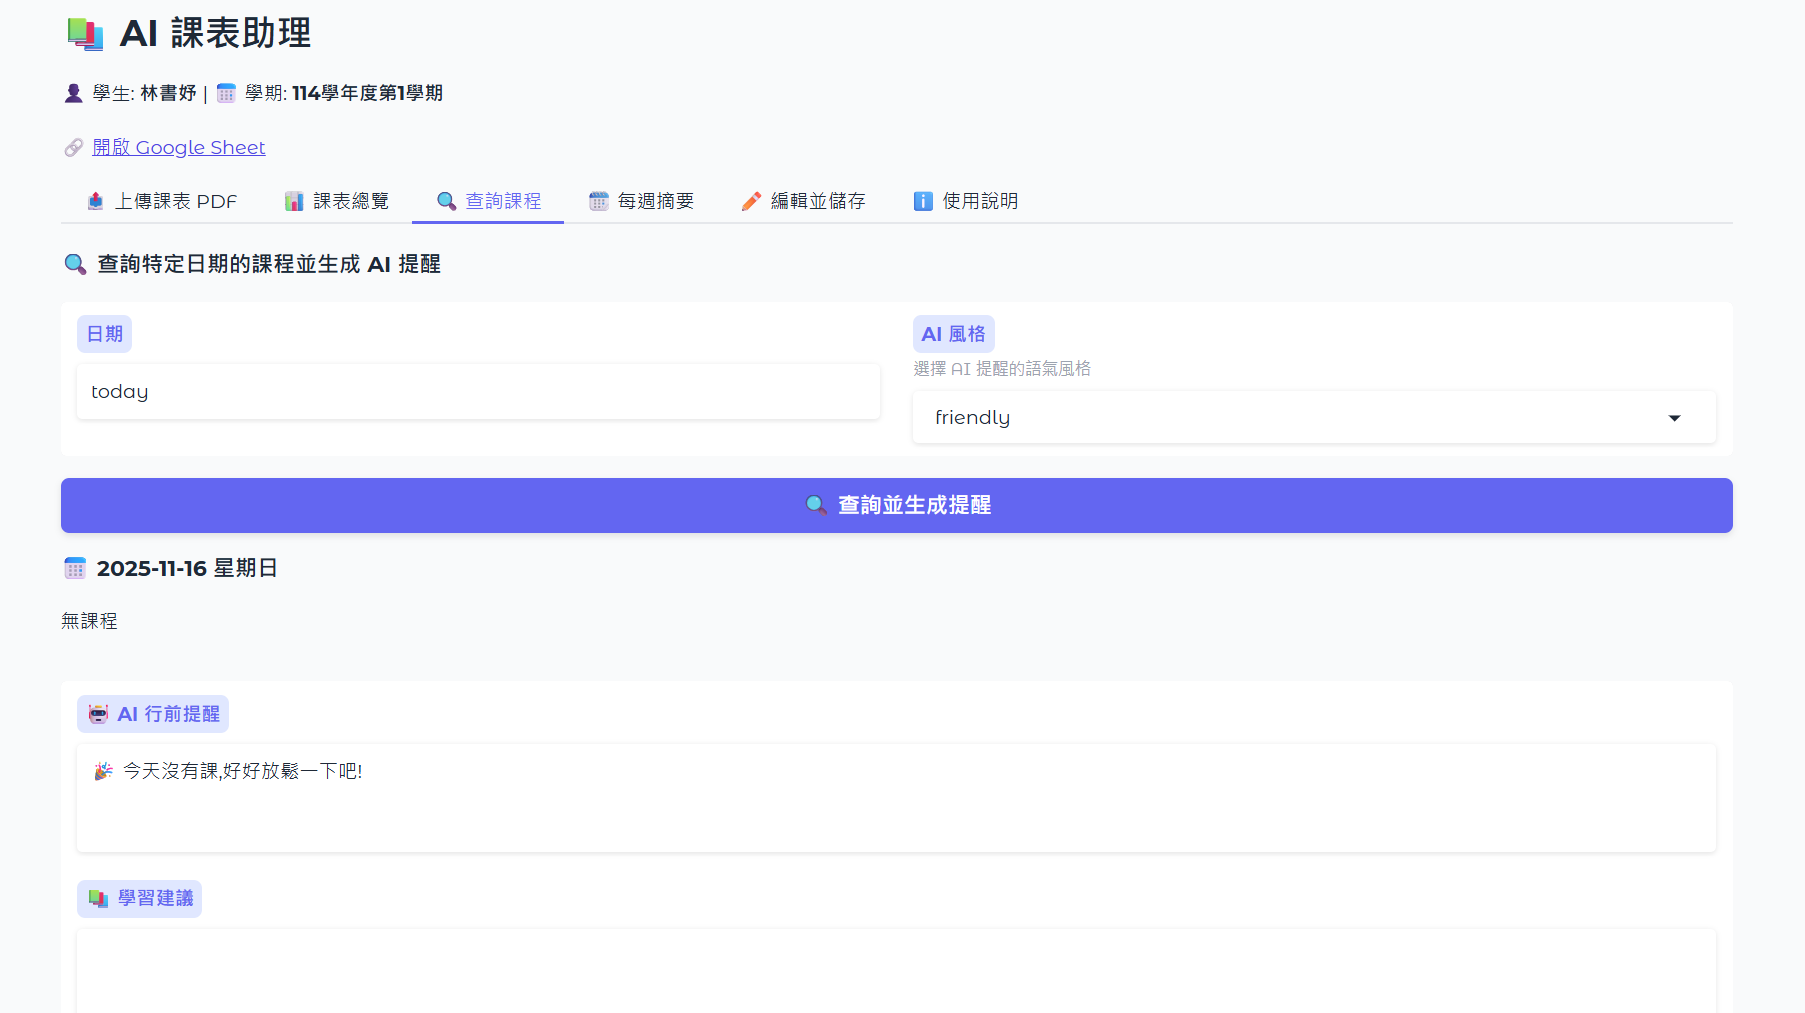

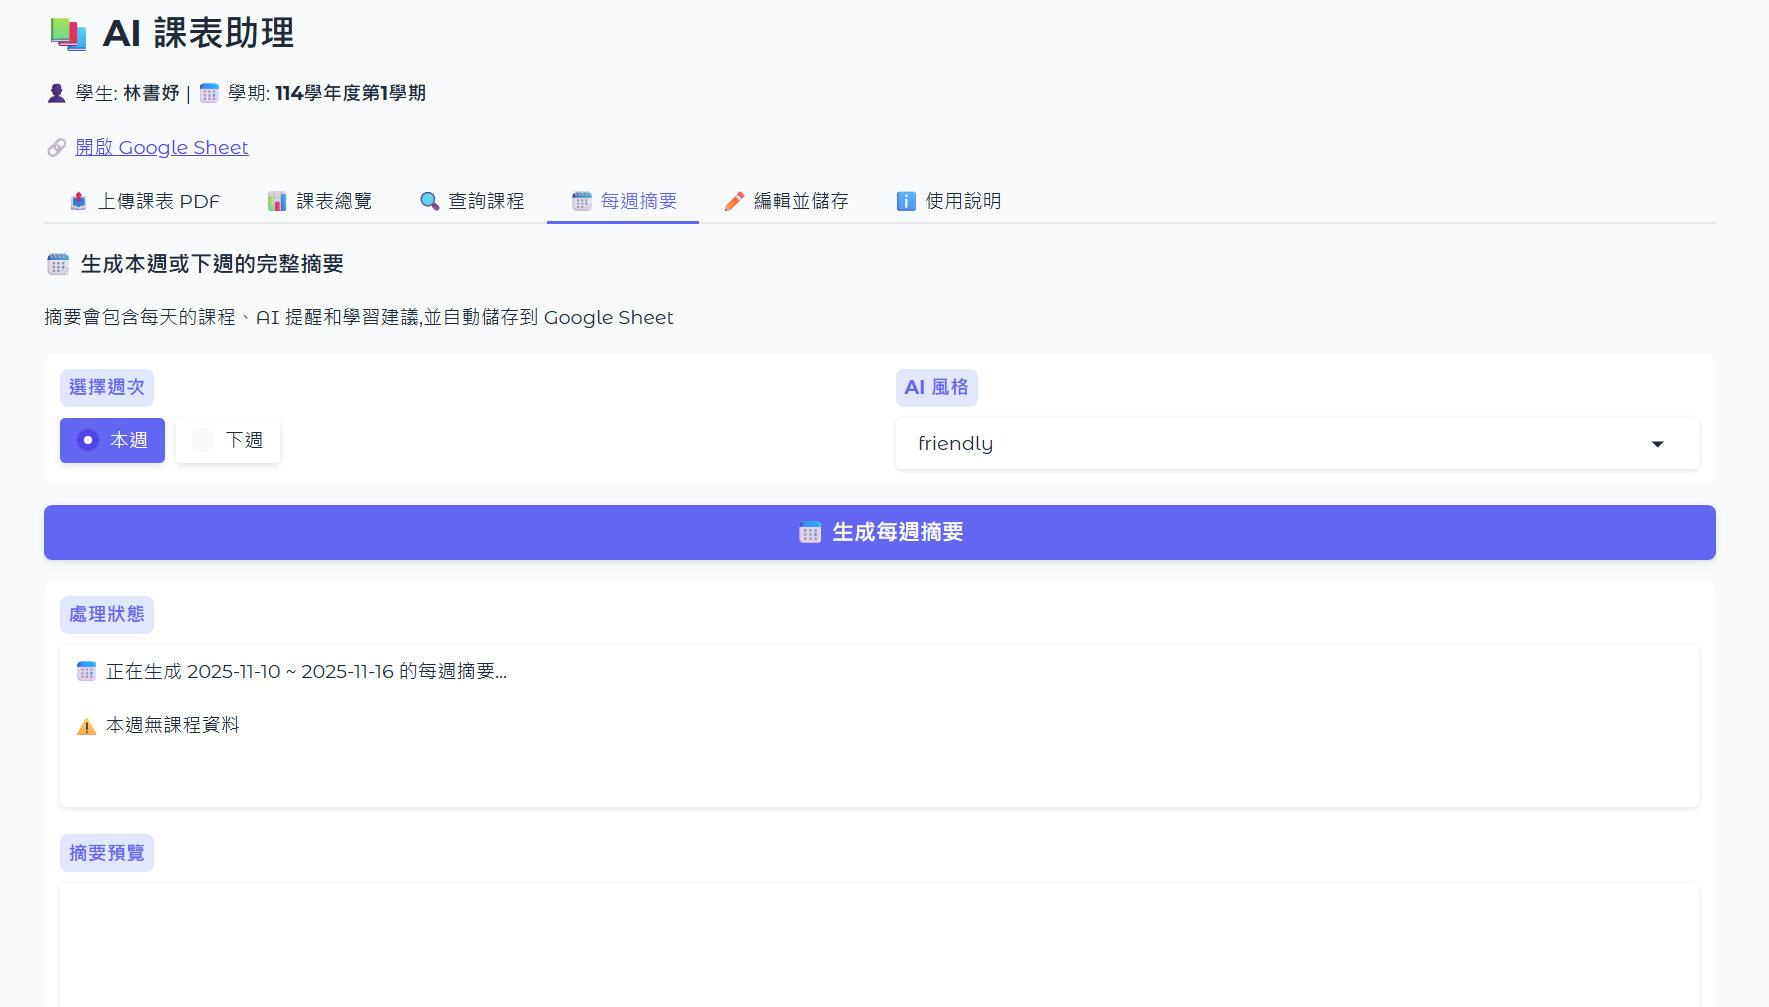

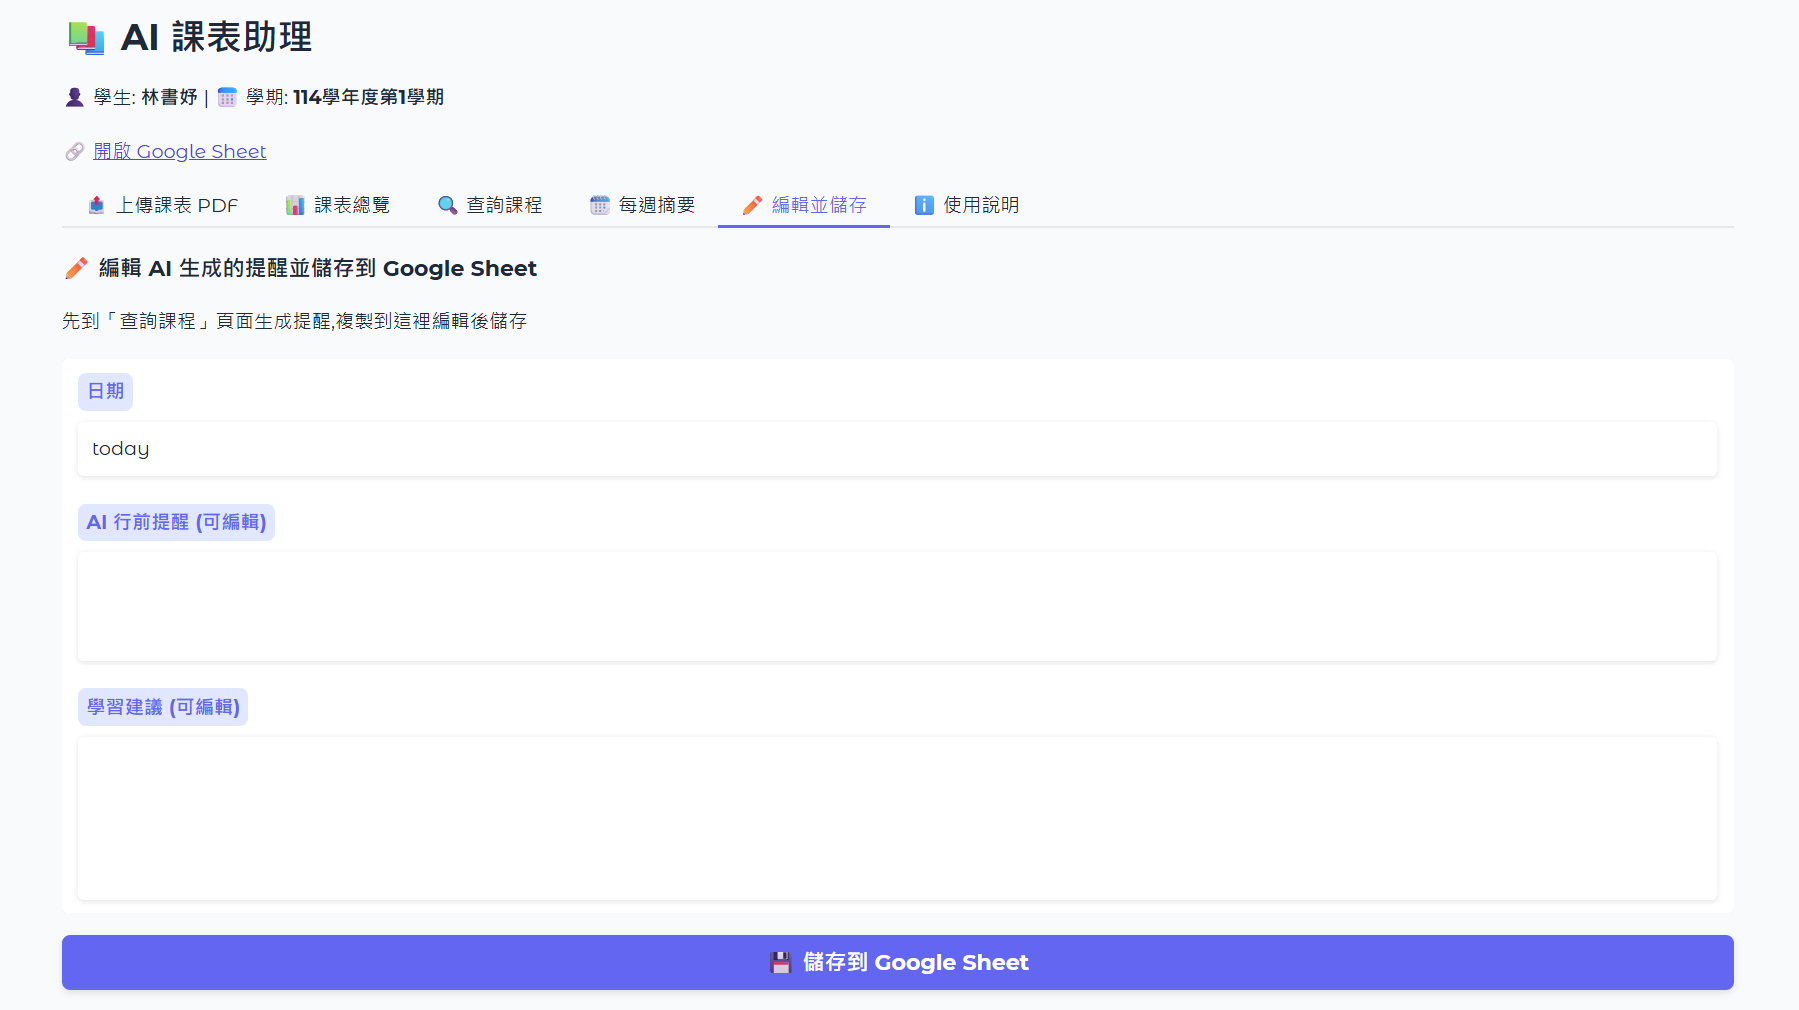

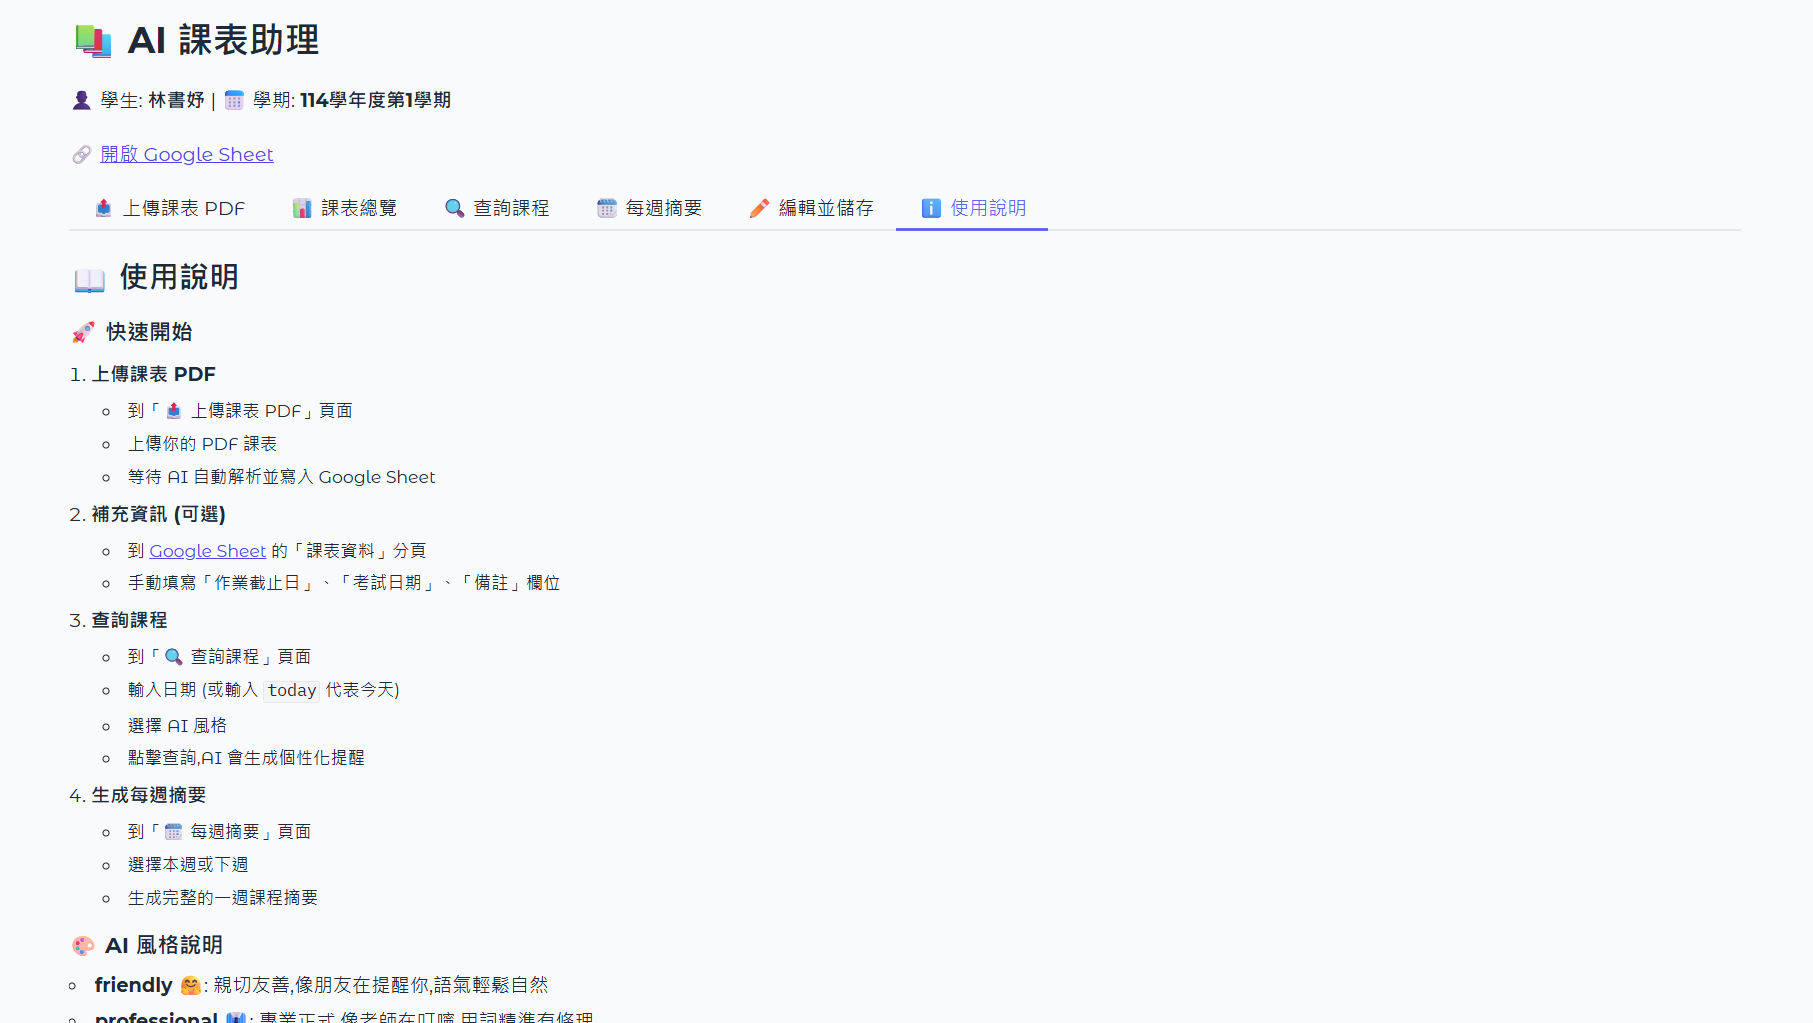

## 程式碼

In [15]:
# ═══════════════════════════════════════
# Cell 1: 環境設定與套件安裝
# ═══════════════════════════════════════

!pip install -q google-generativeai gspread gspread-dataframe gradio python-dateutil pytz

print("✅ 套件安裝完成!")

✅ 套件安裝完成!


In [23]:
# ═══════════════════════════════════════
# Cell 2: Google 認證 + Gemini API
# ═══════════════════════════════════════

import os, time, uuid, re, json, datetime
from datetime import datetime as dt, timedelta
from dateutil.tz import gettz
import pandas as pd
import pytz
import gradio as gr
import google.generativeai as genai

# Google Auth & Sheets
from google.colab import auth, userdata
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.auth import default

# 1. Google 身份驗證
print("🔐 正在進行 Google 身份驗證...")
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
print("✅ Google 認證完成!")

# 2. Gemini API 設定
print("\n🤖 正在設定 Gemini API...")
try:
    api_key = userdata.get('GEMINI_API_KEY')  # 從 Colab Secrets 取得
    genai.configure(api_key=api_key)
    print("✅ Gemini API 設定完成!")
except Exception as e:
    print(f"❌ Gemini API 設定失敗: {e}")
    print("請到 Colab 左側 🔑 Secrets 中新增 'gemini' 金鑰")

🔐 正在進行 Google 身份驗證...
✅ Google 認證完成!

🤖 正在設定 Gemini API...
✅ Gemini API 設定完成!


In [17]:
# ═══════════════════════════════════════
# Cell 3: 使用者設定區 (請修改這裡!)
# ═══════════════════════════════════════

# === Google Sheet 設定 ===
SHEET_URL = "https://docs.google.com/spreadsheets/d/1CUr4MiWalSyXwTVjteZ_FCrFEIoDzs2QidUomHzLdeg/edit?usp=sharing"  # ⚠️ 改成你的 Google Sheet 連結
WORKSHEET_NAME = "課表資料"          # 存放課表的分頁名稱
WEEKLY_SUMMARY_PREFIX = "Week_"     # 每週摘要分頁前綴

# === 學期資訊 (請根據實際情況修改) ===
SEMESTER_NAME = "114學年度第1學期"
SEMESTER_START = "2025/09/15"       # 學期開始日期 ⚠️ 改成實際日期
SEMESTER_END = "2026/01/09"         # 學期結束日期 ⚠️ 改成實際日期
STUDENT_NAME = "林書妤"             # 學生姓名 ⚠️ 改成你的名字

# === 時區設定 ===
TIMEZONE = "Asia/Taipei"
TW_TZ = pytz.timezone(TIMEZONE)

# === AI 風格選項 ===
AI_STYLES = {
    "friendly": "親切友善,像朋友在提醒你,語氣輕鬆自然",
    "professional": "專業正式,像老師在叮嚀,用詞精準有條理",
    "humorous": "幽默風趣,適度加點梗和網路用語,讓人會心一笑",
    "motivational": "激勵鼓舞,充滿正能量,給予信心和動力"
}

print("=" * 50)
print("📋 設定檔載入完成")
print("=" * 50)
print(f"📊 Google Sheet: {SHEET_URL[:50]}...")
print(f"📅 學期: {SEMESTER_NAME}")
print(f"📆 日期: {SEMESTER_START} ~ {SEMESTER_END}")
print(f"👤 學生: {STUDENT_NAME}")
print(f"🎨 AI 風格: {', '.join(AI_STYLES.keys())}")
print("=" * 50)

📋 設定檔載入完成
📊 Google Sheet: https://docs.google.com/spreadsheets/d/1CUr4MiWalS...
📅 學期: 114學年度第1學期
📆 日期: 2025/09/15 ~ 2026/01/09
👤 學生: 林書妤
🎨 AI 風格: friendly, professional, humorous, motivational


In [25]:
# ═══════════════════════════════════════
# Cell 4: 工具函式定義
# ═══════════════════════════════════════

import json
from datetime import datetime, timedelta

# ============================================
# 1. PDF 處理函式
# ============================================

def parse_pdf_with_gemini(pdf_file_path):
    """
    用 Gemini 解析 PDF 課表

    Parameters:
    - pdf_file_path: PDF 檔案路徑

    Returns:
    - tuple: (success, message, csv_content)
    """
    try:
        # 上傳到 Gemini
        gemini_file = genai.upload_file(
            path=pdf_file_path,
            display_name=f"{SEMESTER_NAME} 課程表"
        )

        # Prompt
        prompt = f"""
你是一位專業的課表分析助理。
請分析我上傳的 PDF 課表檔案。

這份 PDF 課表是「{SEMESTER_NAME}」的課程表。
學期開學日是 {SEMESTER_START},學期結束日是 {SEMESTER_END}。

請幫我將這份課表,轉換成每周的紀錄。

你的輸出**必須**是 CSV 格式,並且**只**輸出 CSV 內容 (包含標頭),
不要有任何其他說明文字。

CSV 格式的欄位必須如下:
"日期","星期","課程名稱","時間(起)","時間(迄)","地點","攜帶品","先讀章節","作業截止日","考試日期","備註"

重要規則:
- 「日期」格式: YYYY/MM/DD
- 「星期」格式: 一、二、三、四、五、六、日
- 「日期」範圍請涵蓋 {SEMESTER_START} 到 {SEMESTER_END} 之間所有有課的日期
- 「攜帶品」、「先讀章節」如果 PDF 中有提到請提取,沒有則留空
- 「作業截止日」、「考試日期」、「備註」請保持空白
"""

        # 呼叫 API
        model = genai.GenerativeModel('gemini-2.0-flash-exp')
        response = model.generate_content([prompt, gemini_file])

        # 清理輸出
        csv_content = response.text.strip()
        csv_content = csv_content.replace("```csv\n", "").replace("```csv", "").replace("```", "").strip()

        # 刪除遠端檔案
        genai.delete_file(gemini_file.name)

        return True, "✅ PDF 解析成功!", csv_content

    except Exception as e:
        return False, f"❌ PDF 解析失敗: {str(e)}", None


def save_to_google_sheet(csv_content):
    """
    將 CSV 內容寫入 Google Sheet (改良版,處理格式錯誤)

    Parameters:
    - csv_content: CSV 格式的字串

    Returns:
    - tuple: (success, message)
    """
    try:
        from io import StringIO
        import csv

        # 方法 1: 嘗試用 pandas 讀取
        try:
            df = pd.read_csv(StringIO(csv_content))
            df = df.fillna('')
            print("✅ 使用 pandas 成功解析 CSV")
        except Exception as e1:
            print(f"⚠️ pandas 解析失敗: {e1}")
            print("🔄 嘗試使用 csv.reader 手動解析...")

            # 方法 2: 手動解析 CSV (更寬容)
            try:
                lines = csv_content.strip().split('\n')
                reader = csv.reader(lines, quotechar='"', delimiter=',',
                                   quoting=csv.QUOTE_ALL, skipinitialspace=True)
                data = list(reader)

                if len(data) < 2:
                    return False, "❌ CSV 資料不完整 (少於 2 行)"

                # 轉成 DataFrame
                df = pd.DataFrame(data[1:], columns=data[0])
                df = df.fillna('')
                print(f"✅ 手動解析成功,共 {len(df)} 筆資料")

            except Exception as e2:
                print(f"⚠️ 手動解析也失敗: {e2}")
                print("🔄 最後嘗試: 逐行清理後解析...")

                # 方法 3: 逐行清理 (最寬容)
                try:
                    lines = csv_content.strip().split('\n')
                    cleaned_lines = []

                    for i, line in enumerate(lines):
                        # 移除可能的問題字符
                        line = line.replace('\r', '')
                        # 確保引號配對
                        quote_count = line.count('"')
                        if quote_count % 2 != 0:
                            print(f"⚠️ 第 {i+1} 行引號不配對,嘗試修正")
                            line += '"'
                        cleaned_lines.append(line)

                    cleaned_csv = '\n'.join(cleaned_lines)
                    df = pd.read_csv(StringIO(cleaned_csv))
                    df = df.fillna('')
                    print(f"✅ 清理後解析成功,共 {len(df)} 筆資料")

                except Exception as e3:
                    # 如果還是失敗,儲存 CSV 讓使用者檢查
                    error_file = "error_csv_debug.txt"
                    with open(error_file, 'w', encoding='utf-8') as f:
                        f.write(csv_content)

                    return False, f"""❌ CSV 解析完全失敗

錯誤訊息: {str(e3)}

已將 Gemini 生成的 CSV 儲存到 '{error_file}',請檢查內容。

可能的原因:
1. Gemini 生成的 CSV 格式不正確
2. 課表 PDF 內容太複雜
3. 某些課程名稱包含特殊字符

建議解決方法:
1. 重新上傳 PDF 再試一次
2. 或手動修正 '{error_file}' 後重新上傳
"""

        # 驗證 DataFrame 必要欄位
        required_columns = ["日期", "星期", "課程名稱", "時間(起)", "時間(迄)", "地點"]
        missing_columns = [col for col in required_columns if col not in df.columns]

        if missing_columns:
            return False, f"❌ CSV 缺少必要欄位: {', '.join(missing_columns)}"

        # 確保所有必要欄位都存在
        expected_columns = ["日期", "星期", "課程名稱", "時間(起)", "時間(迄)",
                          "地點", "攜帶品", "先讀章節", "作業截止日", "考試日期", "備註"]

        for col in expected_columns:
            if col not in df.columns:
                df[col] = ''

        # 重新排序欄位
        df = df[expected_columns]

        # 開啟 Google Sheet
        print("📊 正在連接 Google Sheet...")
        gsheets = gc.open_by_url(SHEET_URL)

        # 取得或建立分頁
        try:
            worksheet = gsheets.worksheet(WORKSHEET_NAME)
            print(f"✅ 找到分頁 '{WORKSHEET_NAME}'")
        except gspread.exceptions.WorksheetNotFound:
            worksheet = gsheets.add_worksheet(title=WORKSHEET_NAME, rows=500, cols=20)
            print(f"✅ 建立新分頁 '{WORKSHEET_NAME}'")

        # 清空並寫入
        print("🧹 清空舊資料...")
        worksheet.clear()

        print("💾 寫入新資料...")
        data_to_write = [df.columns.values.tolist()] + df.values.tolist()
        worksheet.update(range_name='A1', values=data_to_write)

        return True, f"✅ 成功寫入 {len(df)} 筆課程資料到 Google Sheet!\n\n欄位: {', '.join(df.columns.tolist())}"

    except Exception as e:
        import traceback
        error_detail = traceback.format_exc()

        return False, f"""❌ 寫入失敗: {str(e)}

詳細錯誤:
{error_detail}

請嘗試:
1. 重新執行此 Cell
2. 檢查 Google Sheet 連結是否正確
3. 確認有 Google Sheet 的編輯權限
"""


# ============================================
# 2. 資料讀取函式
# ============================================

def load_schedule_from_sheet():
    """
    從 Google Sheet 讀取課表資料

    Returns:
    - tuple: (success, message, dataframe)
    """
    try:
        gsheets = gc.open_by_url(SHEET_URL)
        worksheet = gsheets.worksheet(WORKSHEET_NAME)
        sheets_data = worksheet.get_all_values()

        if len(sheets_data) <= 1:
            return False, "⚠️ Google Sheet 中沒有課表資料,請先上傳 PDF", None

        df = pd.DataFrame(sheets_data[1:], columns=sheets_data[0])
        df['日期'] = pd.to_datetime(df['日期'], errors='coerce').dt.date
        df = df.dropna(subset=['日期'])

        return True, f"✅ 成功讀取 {len(df)} 筆課程資料", df

    except gspread.exceptions.WorksheetNotFound:
        return False, f"⚠️ 找不到分頁 '{WORKSHEET_NAME}',請先上傳 PDF 課表", None
    except Exception as e:
        return False, f"❌ 讀取失敗: {str(e)}", None


# ============================================
# 3. AI 提醒生成函式
# ============================================

def make_ai_reminder(day_df, style="friendly", student_name=STUDENT_NAME):
    """生成 AI 行前提醒"""
    if day_df.empty:
        return "🎉 今天沒有課,好好放鬆一下吧!"

    # 準備課程資訊
    course_info = []
    has_homework = False
    has_exam = False

    for _, r in day_df.iterrows():
        info = {
            "課程": r['課程名稱'],
            "時間": f"{r['時間(起)']}-{r['時間(迄)']}",
            "地點": r['地點']
        }

        if str(r.get('攜帶品', '')).strip():
            info["攜帶品"] = r['攜帶品']
        if str(r.get('先讀章節', '')).strip():
            info["預習"] = r['先讀章節']
        if str(r.get('作業截止日', '')).strip():
            info["作業截止日"] = r['作業截止日']
            has_homework = True
        if str(r.get('考試日期', '')).strip():
            info["考試日期"] = r['考試日期']
            has_exam = True
        if str(r.get('備註', '')).strip():
            info["備註"] = r['備註']

        course_info.append(info)

    style_desc = AI_STYLES.get(style, AI_STYLES["friendly"])

    prompt = f"""
你是 {student_name} 的貼心學習助理。根據以下課程資訊,生成一段簡短的行前提醒。

今日課程:
{json.dumps(course_info, ensure_ascii=False, indent=2)}

語氣風格: {style_desc}

要求:
1. 長度: 2-3句話 (最多 100 字)
2. 必須包含的重點:
   - 如果有攜帶品,提醒要帶
   - 如果有預習內容,鼓勵預習
   {'- ⚠️ 如果有作業截止日,**優先提醒剩餘時間**' if has_homework else ''}
   {'- ⚠️ 如果有考試,提醒準備進度' if has_exam else ''}
3. 適度加入 emoji (2-4個)
4. 用「你」稱呼
5. 結尾給予鼓勵

直接輸出提醒內容,不要有前綴說明。
"""

    try:
        model = genai.GenerativeModel('gemini-2.0-flash-exp')
        response = model.generate_content(prompt)
        return response.text.strip()
    except Exception as e:
        return f"⚠️ AI 生成失敗,使用簡易版提醒\n{make_simple_reminder(day_df)}"


def make_learning_advice(day_df, student_name=STUDENT_NAME):
    """生成學習建議"""
    if day_df.empty:
        return ""

    course_list = day_df['課程名稱'].tolist()

    prompt = f"""
你是 {student_name} 的學習顧問。今天的課程: {', '.join(course_list)}

請提供:
1. **課程主題摘要** (1句話,20字內)
2. **學習建議** (2-3個實用建議,每個15-25字)

輸出格式:
📚 今日重點: [摘要]

💡 學習建議:
- [建議1]
- [建議2]
- [建議3]

直接輸出,不要前綴說明。
"""

    try:
        model = genai.GenerativeModel('gemini-2.0-flash-exp')
        response = model.generate_content(prompt)
        return response.text.strip()
    except:
        return f"📚 今日重點: {', '.join(course_list[:3])}\n\n💡 建議專注聽講並做好筆記"


def make_simple_reminder(day_df):
    """簡單規則版提醒 (備用)"""
    if day_df.empty:
        return "今天沒有課程。"

    items = []
    readings = []
    homeworks = []

    for _, r in day_df.iterrows():
        if str(r.get("攜帶品", "")).strip():
            items.append(str(r["攜帶品"]).strip())
        if str(r.get("先讀章節", "")).strip():
            readings.append(str(r["先讀章節"]).strip())
        if str(r.get("作業截止日", "")).strip():
            homeworks.append(f"{r['課程名稱']} ({r['作業截止日']})")

    parts = []
    if items:
        parts.append(f"攜帶: {', '.join(dict.fromkeys(items))}")
    if readings:
        parts.append(f"預習: {', '.join(dict.fromkeys(readings))}")
    if homeworks:
        parts.append(f"作業: {'; '.join(homeworks)}")

    return "; ".join(parts) if parts else "準備好上課用品即可"


# ============================================
# 4. 每週摘要函式
# ============================================

def get_week_range(reference_date=None):
    """取得本週的起訖日期"""
    if reference_date is None:
        reference_date = datetime.now(TW_TZ).date()
    monday = reference_date - timedelta(days=reference_date.weekday())
    sunday = monday + timedelta(days=6)
    return monday, sunday


def create_weekly_summary(df, week_start, week_end, ai_style="friendly"):
    """建立每週摘要並寫入 Google Sheet"""
    sheet_name = f"{WEEKLY_SUMMARY_PREFIX}{week_start.strftime('%m%d')}-{week_end.strftime('%m%d')}"

    # 篩選本週課程
    week_df = df[(df['日期'] >= week_start) & (df['日期'] <= week_end)].copy()

    if week_df.empty:
        return False, "⚠️ 本週無課程資料", None

    # 準備每日摘要
    weekly_data = []
    weekday_names = ["一", "二", "三", "四", "五", "六", "日"]

    for day_offset in range(7):
        current_date = week_start + timedelta(days=day_offset)
        weekday = weekday_names[day_offset]
        day_courses = week_df[week_df['日期'] == current_date].copy().sort_values('時間(起)')

        if day_courses.empty:
            weekly_data.append({
                "日期": current_date.strftime('%Y/%m/%d'),
                "星期": weekday,
                "課程數量": 0,
                "課程列表": "無課程",
                "AI 行前提醒": "🎉 今天沒有課",
                "學習建議": "",
                "作業提醒": ""
            })
        else:
            # 課程列表
            course_list = "; ".join([
                f"{r['時間(起)']}-{r['時間(迄)']} {r['課程名稱']} @ {r['地點']}"
                for _, r in day_courses.iterrows()
            ])

            # AI 提醒
            ai_reminder = make_ai_reminder(day_courses, style=ai_style)
            learning_advice = make_learning_advice(day_courses)

            # 作業提醒
            homework_list = [
                f"{r['課程名稱']}: {r['作業截止日']}"
                for _, r in day_courses.iterrows()
                if str(r.get('作業截止日', '')).strip()
            ]
            homework_text = "; ".join(homework_list)

            weekly_data.append({
                "日期": current_date.strftime('%Y/%m/%d'),
                "星期": weekday,
                "課程數量": len(day_courses),
                "課程列表": course_list,
                "AI 行前提醒": ai_reminder,
                "學習建議": learning_advice,
                "作業提醒": homework_text
            })

    # 寫入 Google Sheet
    try:
        df_weekly = pd.DataFrame(weekly_data)
        gsheets = gc.open_by_url(SHEET_URL)

        try:
            worksheet = gsheets.worksheet(sheet_name)
        except gspread.exceptions.WorksheetNotFound:
            worksheet = gsheets.add_worksheet(title=sheet_name, rows=100, cols=20)

        worksheet.clear()
        set_with_dataframe(worksheet, df_weekly)

        return True, f"✅ 已建立分頁: {sheet_name}", df_weekly

    except Exception as e:
        return False, f"❌ 寫入失敗: {str(e)}", None


# ============================================
# 5. 輔助函式
# ============================================

def parse_target_date(date_input):
    """解析目標日期"""
    if date_input.lower() == "today":
        return datetime.now(TW_TZ).date()
    else:
        return pd.to_datetime(date_input).date()


def format_course_table(day_df):
    """格式化課程表格"""
    if day_df.empty:
        return "無課程"

    table = "| 時間 | 課程 | 地點 | 攜帶品 | 作業 |\n"
    table += "|------|------|------|--------|------|\n"

    for _, r in day_df.iterrows():
        table += f"| {r['時間(起)']}-{r['時間(迄)']} | {r['課程名稱']} | {r['地點']} | {r.get('攜帶品', '')} | {r.get('作業截止日', '')} |\n"

    return table


print("=" * 50)
print("✅ 所有工具函式已載入完成")
print("=" * 50)
print("📌 功能清單:")
print("  • PDF 解析與上傳")
print("  • 課表資料讀取")
print("  • AI 提醒生成")
print("  • 每週摘要建立")
print("=" * 50)

✅ 所有工具函式已載入完成
📌 功能清單:
  • PDF 解析與上傳
  • 課表資料讀取
  • AI 提醒生成
  • 每週摘要建立


In [26]:
### ✅ Cell 5: Gradio 完整介面 (很長,完整複製)
# ═══════════════════════════════════════
# Cell 5: Gradio 完整介面
# ═══════════════════════════════════════

import gradio as gr

# 全域變數儲存課表資料
global_df = None

# ============================================
# Gradio 回調函式
# ============================================

def upload_and_parse_pdf(pdf_file):
    """上傳並解析 PDF"""
    global global_df

    if pdf_file is None:
        return "⚠️ 請先上傳 PDF 檔案", ""

    try:
        # 1. 解析 PDF
        status_msg = "🤖 正在用 Gemini 解析 PDF...\n"
        success, msg, csv_content = parse_pdf_with_gemini(pdf_file.name)
        status_msg += msg + "\n"

        if not success:
            return status_msg, ""

        # 2. 寫入 Google Sheet
        status_msg += "\n💾 正在寫入 Google Sheet...\n"
        success, msg = save_to_google_sheet(csv_content)
        status_msg += msg + "\n"

        if not success:
            return status_msg, ""

        # 3. 重新讀取資料
        status_msg += "\n📊 正在載入課表資料...\n"
        success, msg, df = load_schedule_from_sheet()
        status_msg += msg + "\n"

        if success:
            global_df = df
            status_msg += f"\n✅ 完成! 共載入 {len(df)} 筆課程資料"
            status_msg += f"\n📅 日期範圍: {df['日期'].min()} ~ {df['日期'].max()}"
            status_msg += f"\n📚 課程列表: {', '.join(df['課程名稱'].unique()[:5])}"

            # 返回預覽
            preview = df.head(10).to_markdown(index=False)
            return status_msg, preview
        else:
            return status_msg, ""

    except Exception as e:
        return f"❌ 處理失敗: {str(e)}", ""


def reload_schedule():
    """重新載入課表"""
    global global_df

    success, msg, df = load_schedule_from_sheet()

    if success:
        global_df = df
        stats = f"""
### 📊 課表統計

- **總課程數**: {len(df)} 筆
- **日期範圍**: {df['日期'].min()} ~ {df['日期'].max()}
- **課程列表**: {', '.join(df['課程名稱'].unique())}
- **已填作業**: {df[df['作業截止日'].str.strip() != ''].shape[0]} 筆
- **已填考試**: {df[df['考試日期'].str.strip() != ''].shape[0]} 筆

💡 **提示**: 可以到 [Google Sheet]({SHEET_URL}) 手動補充作業和考試資訊
"""
        preview = df.head(20).to_markdown(index=False)
        return msg, stats, preview
    else:
        return msg, "", ""


def query_and_generate(date_input, style_input):
    """查詢課程並生成 AI 提醒"""
    global global_df

    if global_df is None:
        return "⚠️ 請先上傳 PDF 課表或載入現有課表", "", "", ""

    try:
        target_date = parse_target_date(date_input)
        day_df = global_df[global_df['日期'] == target_date].copy().sort_values('時間(起)')

        if day_df.empty:
            weekday = ["一", "二", "三", "四", "五", "六", "日"][target_date.weekday()]
            course_summary = f"### 📅 {target_date} 星期{weekday}\n\n無課程"
            ai_reminder = "🎉 今天沒有課,好好放鬆一下吧!"
            learning_advice = ""
            table = ""
        else:
            weekday = ["一", "二", "三", "四", "五", "六", "日"][target_date.weekday()]

            # 課程表格
            course_summary = f"### 📅 {target_date} 星期{weekday}\n\n"
            course_summary += f"共 {len(day_df)} 堂課\n\n"

            table = format_course_table(day_df)

            # AI 提醒
            ai_reminder = make_ai_reminder(day_df, style=style_input)
            learning_advice = make_learning_advice(day_df)

        return course_summary, table, ai_reminder, learning_advice

    except Exception as e:
        return f"❌ 查詢失敗: {str(e)}", "", "", ""


def generate_weekly_summary(week_option, style_input):
    """生成每週摘要"""
    global global_df

    if global_df is None:
        return "⚠️ 請先上傳 PDF 課表或載入現有課表", ""

    try:
        # 確定週次
        if week_option == "本週":
            week_start, week_end = get_week_range()
        else:  # 下週
            today = datetime.now(TW_TZ).date()
            next_monday = today + timedelta(days=(7 - today.weekday()))
            week_start, week_end = get_week_range(next_monday)

        # 生成摘要
        status_msg = f"📅 正在生成 {week_start} ~ {week_end} 的每週摘要...\n\n"

        success, msg, df_weekly = create_weekly_summary(
            global_df, week_start, week_end, ai_style=style_input
        )

        status_msg += msg + "\n"

        if success and df_weekly is not None:
            preview = df_weekly.to_markdown(index=False)
            status_msg += f"\n✅ 摘要已寫入 Google Sheet"
            return status_msg, preview
        else:
            return status_msg, ""

    except Exception as e:
        return f"❌ 生成失敗: {str(e)}", ""


def save_edited_reminder(date_input, reminder_text, advice_text):
    """儲存編輯後的提醒"""
    try:
        target_date = parse_target_date(date_input)
        now_str = datetime.now(TW_TZ).strftime("%Y-%m-%d %H:%M")

        gsheets = gc.open_by_url(SHEET_URL)
        try:
            wk = gsheets.worksheet("本週重點")
        except:
            wk = gsheets.add_worksheet(title="本週重點", rows=100, cols=20)

        try:
            existing = pd.DataFrame(wk.get_all_records())
        except:
            existing = pd.DataFrame()

        new_row = {
            "日期": str(target_date),
            "AI 行前提醒": reminder_text,
            "學習建議": advice_text,
            "更新時間": now_str
        }

        if existing.empty:
            outdf = pd.DataFrame([new_row])
        else:
            outdf = pd.concat([existing, pd.DataFrame([new_row])], ignore_index=True)

        wk.clear()
        set_with_dataframe(wk, outdf)

        return f"✅ 已儲存至「本週重點」分頁 (共 {len(outdf)} 筆記錄)\n\n[🔗 開啟 Google Sheet]({SHEET_URL})"

    except Exception as e:
        return f"❌ 儲存失敗: {str(e)}"


# ============================================
# Gradio 介面
# ============================================

with gr.Blocks(title="📚 AI 課表助理", theme=gr.themes.Soft()) as demo:

    gr.Markdown("# 📚 AI 課表助理")
    gr.Markdown(f"👤 學生: **{STUDENT_NAME}** | 📅 學期: **{SEMESTER_NAME}**")
    gr.Markdown(f"🔗 [開啟 Google Sheet]({SHEET_URL})")

    # ============================================
    # Tab 1: 上傳課表 PDF
    # ============================================

    with gr.Tab("📤 上傳課表 PDF"):
        gr.Markdown("""
        ### 📤 上傳你的課表 PDF

        1. 點擊下方按鈕上傳 PDF 檔案
        2. AI 會自動解析課表內容
        3. 解析完成後會自動寫入 Google Sheet

        ⚠️ **注意**: 上傳後請到 Google Sheet 手動補充「作業截止日」和「考試日期」
        """)

        pdf_upload = gr.File(
            label="選擇 PDF 檔案",
            file_types=[".pdf"],
            type="filepath"
        )

        upload_btn = gr.Button("🚀 開始解析並上傳", variant="primary", size="lg")

        upload_status = gr.Textbox(label="處理狀態", lines=10)
        upload_preview = gr.Textbox(label="課表預覽 (前 10 筆)", lines=15)

        upload_btn.click(
            upload_and_parse_pdf,
            inputs=[pdf_upload],
            outputs=[upload_status, upload_preview]
        )

    # ============================================
    # Tab 2: 課表總覽
    # ============================================

    with gr.Tab("📊 課表總覽"):
        gr.Markdown("### 📊 查看完整課表與統計")

        reload_btn = gr.Button("🔄 重新載入課表", variant="secondary")

        overview_status = gr.Markdown()
        overview_stats = gr.Markdown()
        overview_table = gr.Textbox(label="完整課表", lines=20)

        reload_btn.click(
            reload_schedule,
            outputs=[overview_status, overview_stats, overview_table]
        )

    # ============================================
    # Tab 3: 查詢課程
    # ============================================

    with gr.Tab("🔍 查詢課程"):
        gr.Markdown("### 🔍 查詢特定日期的課程並生成 AI 提醒")

        with gr.Row():
            query_date = gr.Textbox(
                label="日期",
                placeholder="輸入 'today' 或 'YYYY/MM/DD' (例如: 2025/11/18)",
                value="today"
            )
            query_style = gr.Dropdown(
                choices=list(AI_STYLES.keys()),
                label="AI 風格",
                value="friendly",
                info="選擇 AI 提醒的語氣風格"
            )

        query_btn = gr.Button("🔍 查詢並生成提醒", variant="primary")

        query_summary = gr.Markdown()
        query_table = gr.Markdown(label="課程表格")
        query_reminder = gr.Textbox(label="🤖 AI 行前提醒", lines=3)
        query_advice = gr.Textbox(label="📚 學習建議", lines=5)

        query_btn.click(
            query_and_generate,
            inputs=[query_date, query_style],
            outputs=[query_summary, query_table, query_reminder, query_advice]
        )

    # ============================================
    # Tab 4: 每週摘要
    # ============================================

    with gr.Tab("🗓️ 每週摘要"):
        gr.Markdown("### 🗓️ 生成本週或下週的完整摘要")
        gr.Markdown("摘要會包含每天的課程、AI 提醒和學習建議,並自動儲存到 Google Sheet")

        with gr.Row():
            week_select = gr.Radio(
                choices=["本週", "下週"],
                label="選擇週次",
                value="本週"
            )
            weekly_style = gr.Dropdown(
                choices=list(AI_STYLES.keys()),
                label="AI 風格",
                value="friendly"
            )

        weekly_btn = gr.Button("📅 生成每週摘要", variant="primary", size="lg")

        weekly_status = gr.Textbox(label="處理狀態", lines=5)
        weekly_preview = gr.Textbox(label="摘要預覽", lines=20)

        weekly_btn.click(
            generate_weekly_summary,
            inputs=[week_select, weekly_style],
            outputs=[weekly_status, weekly_preview]
        )

    # ============================================
    # Tab 5: 編輯並儲存
    # ============================================

    with gr.Tab("✏️ 編輯並儲存"):
        gr.Markdown("### ✏️ 編輯 AI 生成的提醒並儲存到 Google Sheet")
        gr.Markdown("先到「查詢課程」頁面生成提醒,複製到這裡編輯後儲存")

        edit_date = gr.Textbox(
            label="日期",
            placeholder="YYYY/MM/DD",
            value="today"
        )
        edit_reminder = gr.Textbox(label="AI 行前提醒 (可編輯)", lines=3)
        edit_advice = gr.Textbox(label="學習建議 (可編輯)", lines=5)

        save_btn = gr.Button("💾 儲存到 Google Sheet", variant="primary")
        save_status = gr.Markdown()

        save_btn.click(
            save_edited_reminder,
            inputs=[edit_date, edit_reminder, edit_advice],
            outputs=[save_status]
        )

    # ============================================
    # Tab 6: 使用說明
    # ============================================

    with gr.Tab("ℹ️ 使用說明"):
        gr.Markdown(f"""
        ## 📖 使用說明

        ### 🚀 快速開始

        1. **上傳課表 PDF**
           - 到「📤 上傳課表 PDF」頁面
           - 上傳你的 PDF 課表
           - 等待 AI 自動解析並寫入 Google Sheet

        2. **補充資訊 (可選)**
           - 到 [Google Sheet]({SHEET_URL}) 的「{WORKSHEET_NAME}」分頁
           - 手動填寫「作業截止日」、「考試日期」、「備註」欄位

        3. **查詢課程**
           - 到「🔍 查詢課程」頁面
           - 輸入日期 (或輸入 `today` 代表今天)
           - 選擇 AI 風格
           - 點擊查詢,AI 會生成個性化提醒

        4. **生成每週摘要**
           - 到「🗓️ 每週摘要」頁面
           - 選擇本週或下週
           - 生成完整的一週課程摘要

        ### 🎨 AI 風格說明

        - **friendly** 🤗: 親切友善,像朋友在提醒你,語氣輕鬆自然
        - **professional** 👔: 專業正式,像老師在叮嚀,用詞精準有條理
        - **humorous** 😄: 幽默風趣,適度加點梗和網路用語,讓人會心一笑
        - **motivational** 💪: 激勵鼓舞,充滿正能量,給予信心和動力

        ### 📊 Google Sheet 分頁說明

        - **{WORKSHEET_NAME}**: 完整課表資料 (可手動編輯補充作業/考試資訊)
        - **Week_MMDD-MMDD**: 每週摘要 (自動生成,包含 AI 提醒)
        - **本週重點**: 儲存編輯過的提醒內容

        ### 💡 使用技巧

        - 定期到 Google Sheet 更新作業和考試資訊,AI 提醒會更精準
        - 不同場合可以嘗試不同的 AI 風格
        - 每週摘要可以幫你提前規劃一週的學習
        - 編輯功能讓你可以保存個性化的提醒內容

        ### 🔗 連結

        - [Google Sheet]({SHEET_URL})
        - 學期: {SEMESTER_NAME} ({SEMESTER_START} ~ {SEMESTER_END})
        """)

# 啟動介面
print("=" * 50)
print("🚀 正在啟動 Gradio 介面...")
print("=" * 50)

demo.launch(share=True, inline=True, debug=True)

🚀 正在啟動 Gradio 介面...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://26c8d9c8603421a7a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

✅ 使用 pandas 成功解析 CSV
📊 正在連接 Google Sheet...
✅ 建立新分頁 '課表資料'
🧹 清空舊資料...
💾 寫入新資料...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://26c8d9c8603421a7a9.gradio.live
